In [1]:
# (C) Copyright 1996- ECMWF.
#
# This software is licensed under the terms of the Apache Licence Version 2.0
# which can be obtained at http://www.apache.org/licenses/LICENSE-2.0.
# In applying this licence, ECMWF does not waive the privileges and immunities
# granted to it by virtue of its status as an intergovernmental organisation
# nor does it submit to any jurisdiction.

In [2]:
# basic libraries for data analysis
import numpy as np 
import pandas as pd
import xarray as xr

from itertools import product

# specialized libraries
from eofs.xarray import Eof # EOF analysis
from sklearn.cluster import KMeans # K-means clustering

import multiprocessing # parallel processing
import tqdm # timing

### Input variables

In [3]:
dir_loc = '' 

output_data_file = ''

In [4]:
atm_var_used = ['SLP', 'Z500']
days_shift = 4 # for climatology (use dates before/after date of interest for more robust climatology)
clusters_for_patterns = [9]
area_subset = [50, -11, 26, 41] # boundary used for the Mediterranean Patterns (as in Paper1, Paper2)
rolling_days = [1, 3] # n-days temporal average of instances to be allocated to the large-scale patterns

### Atmospheric Variability

In [5]:
def clim_anom(input_data):
    
    daymonth_used, roll_d = input_data
    
    # keep dates of interest (exact day month)
    dates_used = all_dates_atm_var_extd[all_dates_atm_var_extd.strftime('%m%d').isin([daymonth_used])]
    
    # add buffer days (before/after) for having a more robust climatology for mean and std
    # when considering n-days data (n>1), then use only dates with no overlapping subsets
    all_dates_used = [list(pd.date_range(i_dt, i_dt-pd.DateOffset(days=days_shift), freq='-1D')[::roll_d][::-1])+
                      list(pd.date_range(i_dt, i_dt+pd.DateOffset(days=days_shift), freq='D')[::roll_d][1:]) 
                      for i_dt in dates_used]
    all_dates_used = np.array([j for i in all_dates_used for j in i]) # flatten data to have 1-d array
    all_dates_used = all_dates_used[pd.to_datetime(all_dates_used).isin(all_dates_atm_var)] # only existing dates
    
    # keep all dates of interest and get climatology
    subset_i_date = atm_var_data.sel(time=all_dates_used, rolling=roll_d)
    
    clim_mean = subset_i_date.mean('time')
    clim_std = subset_i_date.std('time')
    
    # get (standardized) anomalies for the exact days of interest
    subset_used = subset_i_date.sel(time=dates_used[dates_used.isin(all_dates_atm_var)])
    anom_mean = subset_used-clim_mean
    anom_std = anom_mean/clim_std
    
    # concatenate all data
    dim_name = pd.Index(['Actual', 'Anomalies', 'Anomalies_Std'], name='variable_type')
    final_subset = xr.concat([subset_used, anom_mean, anom_std], dim=dim_name)
    clim_data = xr.concat([clim_mean, clim_std], dim=pd.Index(['Mean', 'Std'], name='indicator'))
    clim_data = clim_data.assign_coords({'time': daymonth_used})
    
    return final_subset, clim_data

In [6]:
atm_var_data = []
atm_var_data_final = []
clim_ERA5 = []
for i_var in atm_var_used:
    
    # read daily data of the atmospheric variable of interest
    file_path = dir_loc + 'D1_Mean_'+i_var+'.grb'
    daily_data = xr.open_dataarray(file_path, engine='cfgrib').reset_coords(drop=True) # read data
    daily_data = daily_data.astype('float64') # when float64 instead of float32, then analysis is much faster
    daily_data.name = i_var
    # do the final temporal subset at end, so smoothing has all daily data for more robust results
    daily_data = daily_data.sel(time=slice('1979','2019')) # same years as Paper1 & Paper2

    atm_var_data.append(daily_data)
    
atm_var_data = xr.merge(atm_var_data)

atm_var_data = [atm_var_data.rolling(time=i_rol, min_periods=1).mean() for i_rol in rolling_days]
atm_var_data = xr.concat(atm_var_data, dim=pd.Index(rolling_days, name='rolling'))

all_dates_atm_var = pd.to_datetime(atm_var_data.time.values)
# extend the years by 1 before/after for getting all proper dates in climatology (e.g. for date 31 Dec and 4 days
# window, it climatology should also consider 01-04 Jan 1979, making an issue since first Dec is 1979 & not 1978)
all_dates_atm_var_extd = pd.date_range(all_dates_atm_var[0] - pd.DateOffset(years=1), 
                                       all_dates_atm_var[-1] + pd.DateOffset(years=1))
unique_daymonth = all_dates_atm_var.strftime('%m%d')
unique_daymonth = sorted(set(unique_daymonth))


# calculate anomalies and climatology
for i_roll in rolling_days:
    comb_used = list(product(unique_daymonth, [i_roll]))
    pool = multiprocessing.Pool() # object for multiprocessing
    atm_var_i = list(tqdm.tqdm(pool.imap(clim_anom, comb_used), total=len(comb_used), position=0))
    pool.close(); pool.join()

    clim_ERA5_i = xr.concat([i[1] for i in atm_var_i], dim='time')
    clim_ERA5_i = clim_ERA5_i.assign_coords({'days_shift': days_shift}) # information about shifts of days used
    clim_ERA5.append(clim_ERA5_i)
    atm_var_i = xr.concat([i[0] for i in atm_var_i], dim='time')
    atm_var_i = atm_var_i.sortby('time')
    atm_var_data_final.append(atm_var_i)

atm_var_data = xr.concat(atm_var_data_final, dim='rolling')
atm_var_data = atm_var_data.astype('float32')
clim_ERA5 = xr.concat(clim_ERA5, dim='rolling')
clim_ERA5.to_netcdf(f'{output_data_file}ERA5_clim.nc') # save climatology for use later on
    
del(atm_var_data_final, i_var, file_path, daily_data, all_dates_atm_var, all_dates_atm_var_extd, unique_daymonth,
    i_roll, comb_used, pool, atm_var_i, clim_ERA5_i, clim_anom)

100%|█████████████████████████████████████████| 366/366 [00:09<00:00, 37.21it/s]


In [7]:
def eof_analysis(input_data):
    
    variable = input_data[0] # name of variable used (based on the keys of the "atm_var_data" xarray DataSet)
    var_type_used = input_data[1] # is it "Anomalies" or "Anomalies_Std"?
    rolling_used = input_data[2] # what type of n-days aggregation to use?
    
    dataset_used = atm_var_data[variable].sel(variable_type=var_type_used).copy(deep=True) # dataset for analysis
    dataset_used = dataset_used.sel(latitude=slice(area_subset[0], area_subset[2]), # subset area of interest 
                                    longitude=slice(area_subset[1], area_subset[3]),
                                    rolling=rolling_used) # get n-days aggregation of interest    

#     dataset_used = dataset_used.isel(time=range(0, len(dataset_used.time), rolling_used)) # no overlap info

    coslats = np.cos(np.deg2rad(dataset_used.latitude.values)).clip(0, 1) # coslat for weights on EOF
    wgts = np.sqrt(coslats)[..., np.newaxis] # calculation of weights
    solver = Eof(dataset_used, weights=wgts) # EOF analysis of the subset
    
    n_eofs = int(np.searchsorted(np.cumsum(solver.varianceFraction().values), 90/100)) # at least 90% expl.var 
    n_eofs += 1 # add 1 since python does not include the last index of a range
    
    final_EOFS = solver.eofs(neofs=n_eofs)
    
    final_VARS = solver.varianceFraction(neigs=n_eofs).values*100
    
    final_PCS = pd.DataFrame(solver.pcs(npcs=n_eofs).values, index=dataset_used.time.values)
    final_PCS = final_PCS/final_PCS.std() # standardize PCs
    # normal per sqrt of variance so K-means dist is weighted based on the importance of each PC to expl. var.
    final_PCS = final_PCS*np.sqrt(final_VARS)
    
    return {'EOFS': final_EOFS, 'PCS': final_PCS, 'VARS': final_VARS}

In [8]:
def patterns_composites(data, tags):
    
    # calculate patterns composites based on given xarray data, and tags for each (n-day averaged) field
    comp_data = data.assign_coords({'time': tags}).groupby('time').mean() # composites
    comp_data = comp_data.rename({'time': 'cluster'})
    
    return comp_data

In [9]:
def composites_euclidean_distance(daily_data, composites):
    
    # calculate Euclidean distance weighted based on areal differences of each cell (due to latitude)
    # then generate new composites by labeling each field to the cluster of lowest Euclidean distance
    
    lat_weights = np.cos(np.deg2rad(composites.latitude)) # weights due to areal differences of each grid
    
    difs_eucl = daily_data - composites # distance (as in error) per cell from each composite
    difs_eucl = difs_eucl**2 # square of error
    difs_eucl = difs_eucl.weighted(lat_weights).mean(['latitude', 'longitude']) # weighted mean of the difs
    difs_eucl = np.sqrt(difs_eucl) # square root of distance (as in RMSE metric)
    
    difs_eucl_mean = difs_eucl.mean(['time', 'cluster']) # get the average Euclidean distance
    difs_eucl = difs_eucl/difs_eucl_mean # normalise difs from the used variables so values can be comparable
    
    difs_eucl = difs_eucl.to_array('atm_variable')
    difs_eucl = difs_eucl.mean('atm_variable') # mean of differences for all variables
    new_label = difs_eucl.argmin('cluster').values # allocate each field to the cluster of lowest Euclidian dist.
    
    new_composites = patterns_composites(daily_data, new_label) # calculate new composites
    
    return (new_label, new_composites, difs_eucl_mean)

In [10]:
def clustering_atm_data(input_data):
        
    anom_used, rolling_used = input_data
        
    # get PCs of all atm. variables and concatenate to 1 single dataframe
    eofs_all = [eof_analysis([i_var, anom_used, rolling_used]) for i_var in atm_var_used]
    princ_comp = pd.concat([i_eof['PCS'] for i_eof in eofs_all], axis=1) # concatenate all PCs to the final DF
    
    # variables to store data from KMeans clustering for different number of clusters
    column_names = ['Clusters_'+str(i_c) for i_c in clusters_for_patterns] 
    labels_actual_all = pd.DataFrame(np.nan, columns=column_names, index=princ_comp.index)
    labels_all = pd.DataFrame(np.nan, columns=column_names, index=princ_comp.index)
    inertia_all = pd.DataFrame(np.nan,columns=['Inrt_act', 'Inrt_act_mod', 'Inrt', 'Inrt_mod'], 
                               index=column_names)
    convergence_all = pd.DataFrame(np.nan, columns=['N_iterations'], index=column_names)
    comp_final, eucl_mean = [], []
    
    inertia1 = KMeans(n_clusters=1).fit(princ_comp).inertia_ # inertia for 1 cluster for normalizing data later
    for i_c, clusters_used in enumerate(clusters_for_patterns): # loop through number of clusters used
        km_cluster = KMeans(n_clusters=clusters_used, random_state=10) # always same seed for reproducibility
        km_cluster.fit(princ_comp)
        labels_actual_all.iloc[:, i_c] = km_cluster.labels_
        inertia_all.iloc[i_c, 0] = km_cluster.inertia_
        inertia_all.iloc[i_c, 1] = km_cluster.inertia_/inertia1 + .02*i_c # .02*i_c: penalty for more clusters
        
        # get initial composites only based on K-means clustering
        data_used = atm_var_data.sel(variable_type=anom_used,
                                     rolling=rolling_used,
                                     longitude=eofs_all[0]['EOFS'].longitude.values, 
                                     latitude=eofs_all[0]['EOFS'].latitude.values)
        compsKMeans = patterns_composites(data_used, km_cluster.labels_)
        
        'adjust composites based on "min Euclidean dist" between input fields and composites'
        iterations_max = 200
        mismatching_max = 0

        i_iter = 1
        iter_results = composites_euclidean_distance(data_used, compsKMeans)
        mismatch = (iter_results[0] != km_cluster.labels_).sum()/len(km_cluster.labels_)*100

        while mismatch>mismatching_max and i_iter<=iterations_max:
            old_tags = iter_results[0]
            iter_results = composites_euclidean_distance(data_used, iter_results[1])
            mismatch = (iter_results[0] != old_tags).sum()/len(old_tags)*100
            i_iter = i_iter+1

        convergence_all.iloc[i_c, 0] = i_iter if mismatch<=mismatching_max else -1
        
        labels_all.iloc[:, i_c] = iter_results[0]
        
        inertia_final = [((princ_comp[iter_results[0]==i]-princ_comp[iter_results[0]==i].mean())**2).sum().sum()
                         for i in range(clusters_used)]
        inertia_final = sum(inertia_final)
        inertia_all.iloc[i_c, 2] = inertia_final/inertia1
        inertia_all.iloc[i_c, 3] = inertia_final/inertia1 + .02*i_c
        
        comp_final.append(iter_results[1])
        eucl_mean.append(iter_results[2])
        
    comp_final = xr.concat(comp_final, dim=pd.Index(clusters_for_patterns, name='ClustersNumber'))
    eucl_mean = xr.concat(eucl_mean, dim=pd.Index(clusters_for_patterns, name='ClustersNumber'))

    return (inertia_all, convergence_all, comp_final, labels_all, eucl_mean)

In [11]:
all_combs = list(product(['Anomalies', 'Anomalies_Std'], rolling_days)) # all options used for the clustering

pool = multiprocessing.Pool(processes=8) # object for multiprocessing
clusters_final = list(tqdm.tqdm(pool.imap(clustering_atm_data, all_combs), total=len(all_combs), position=0))
pool.close()
del(pool)

100%|█████████████████████████████████████████████| 4/4 [05:40<00:00, 85.20s/it]


In [12]:
# reorder clusters on Anomalies, so we have exactly the same order as the Mediterranean patterns in Papers 1, 2
med_order = [5, 0, 2, 7, 4, 6, 1, 3, 8]
comp_anom = clusters_final[0][-3].copy(deep=True).assign_coords({'cluster': med_order}).sortby('cluster')
labels_anom = clusters_final[0][-2].copy(deep=True)
labels_anom['Clusters_9'] = labels_anom['Clusters_9'].map({i:j for i, j in enumerate(med_order)})

med_order = [2, 0, 3, 8, 1, 6, 7, 4, 5]
comp_anom3 = clusters_final[1][-3].copy(deep=True).assign_coords({'cluster': med_order}).sortby('cluster')
labels_anom3 = clusters_final[1][-2].copy(deep=True)
labels_anom3['Clusters_9'] = labels_anom3['Clusters_9'].map({i:j for i, j in enumerate(med_order)})

comp_anom = xr.concat([comp_anom, comp_anom3], dim='rolling')
dim_name = pd.Index(rolling_days, name='rolling')
labels_anom = xr.concat([xr.DataArray(labels_anom), xr.DataArray(labels_anom3)], dim=dim_name)
labels_anom = labels_anom.rename({'dim_0': 'time', 'dim_1': 'ClustersNumber'})

eucl_anom = xr.concat([i[-1] for i in clusters_final[:2]], dim=dim_name)

comp_anom_std = clusters_final[2][-3]
comp_anom_std3 = clusters_final[3][-3]
comp_anom_std = xr.concat([comp_anom_std, comp_anom_std3], dim='rolling')

labels_anom_std = [xr.DataArray(clusters_final[2][-2]), xr.DataArray(clusters_final[3][-2])]
labels_anom_std = xr.concat(labels_anom_std, dim=dim_name)
labels_anom_std = labels_anom_std.rename({'dim_0': 'time', 'dim_1': 'ClustersNumber'})

eucl_anom_std = xr.concat([i[-1] for i in clusters_final[2:]], dim=dim_name)

composites_all = xr.concat([comp_anom, comp_anom_std], dim='variable_type')
composites_all.to_netcdf(f'{output_data_file}Med_LocalizedPatterns_Composites.nc')

labels_all = xr.concat([labels_anom, labels_anom_std], dim=composites_all.variable_type)
labels_all.to_netcdf(f'{output_data_file}Med_LocalizedPatterns_Labels.nc')

eucl_all = xr.concat([eucl_anom, eucl_anom_std], dim=composites_all.variable_type)
eucl_all.to_netcdf(f'{output_data_file}Med_LocalizedPatterns_EuclMean.nc')

### Visual differences between 3-days and 1-day derived patterns

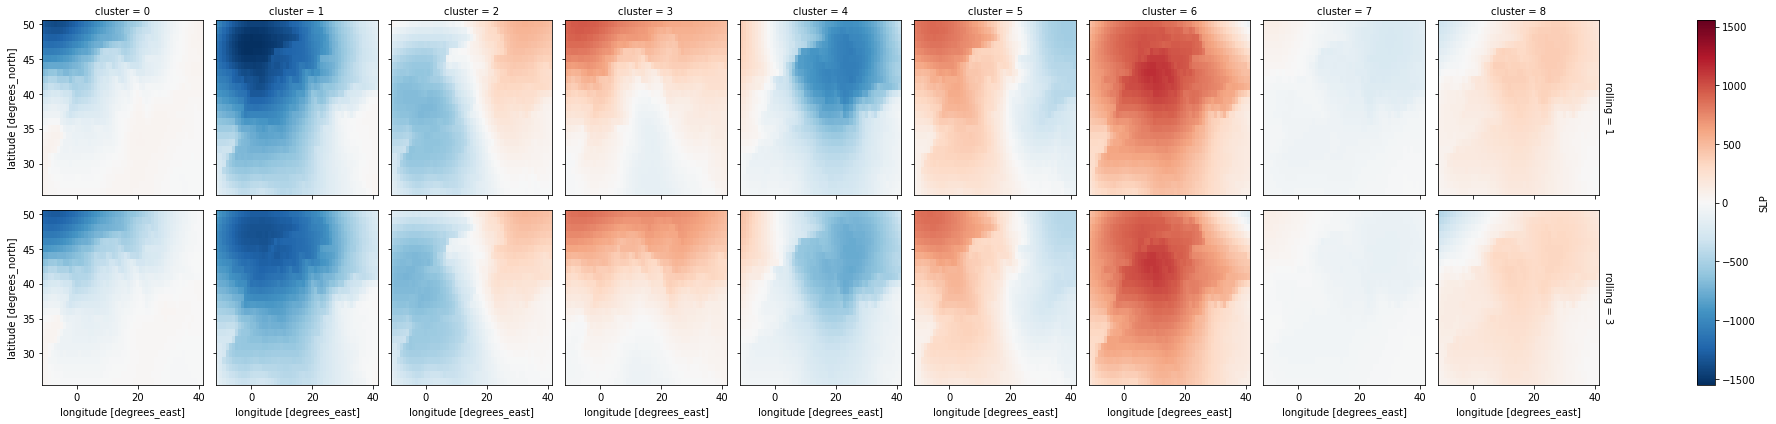

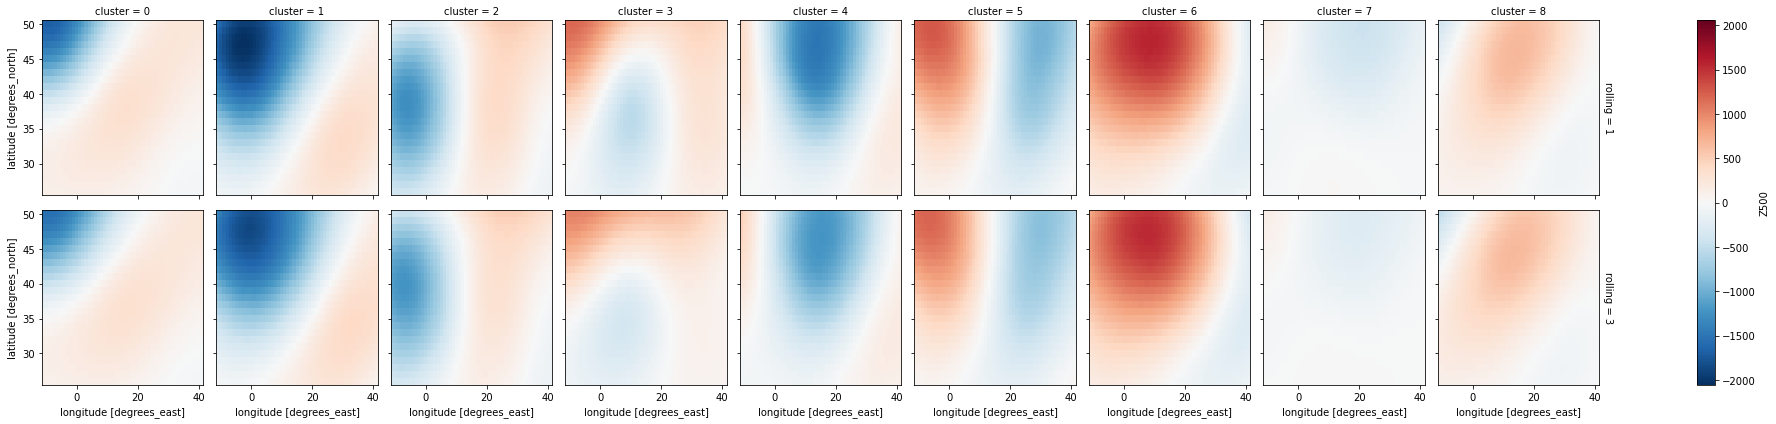

In [13]:
comp_anom['SLP'].plot(col='cluster', row='rolling')
comp_anom['Z500'].plot(col='cluster', row='rolling')